<a href="https://colab.research.google.com/github/sweeneyngo/furspect/blob/master/furspect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 😇 **Preface**

---



In [ ]:
# Download images using simple_image_download
# Thanks Roy for multithreading
# Not sure if it requires Chrome + Webdriver
# https://github.com/Roy6801/simple_image_download

# Download images using e621 downloader
# Compiled in Rust
# https://github.com/McSib/e621_downloader
# See PR/Issue
# fur rating:safe -human -animated -meme -comic -humanoid

# Sources/References
# https://gsurma.medium.com/image-classifier-cats-vs-dogs-with-convolutional-neural-networks-cnns-and-google-colabs-4e9af21ae7a8


# 🧠 **Initial Viewing**

---



## **Loading dataset & directory setup**

> In Google Colaboratory, mounting at Drive is essential for obtaining files stored on Drive. Our dataset is downloaded as a ZIP and stored in its directory, so we need to look for it first (tree is viewable once mounted).

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Locate directory and unzip its contents (we're using `zipfile`) as read-only files.

In [15]:
from zipfile import ZipFile
# Create a ZipFile Object and load dataset.zip
with ZipFile('drive/MyDrive/dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in dataset directory
   zipObj.extractall('dataset')

In [157]:
DATADIR = "dataset/dataset/"
CATEGORIES = ['furry', 'notfurry']
SIZE = 200
RATIO = 0.2
BATCH_SIZE = 32
EPOCHS = 20

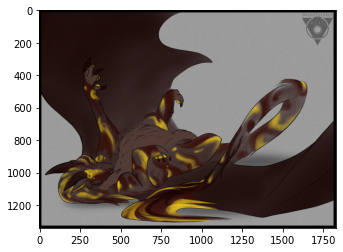

(1341, 1830, 3)


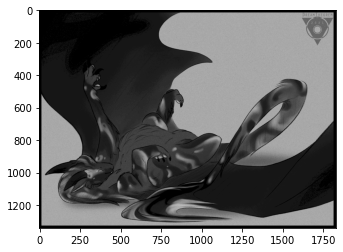

(1341, 1830)


In [145]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

# view image(s)
for dir in CATEGORIES:
  path = os.path.join(DATADIR, dir)
  for img in os.listdir(path):
    arr = cv2.imread(os.path.join(path, img))
    arrg = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(arr)
    plt.show()
    print(arr.shape)

    plt.imshow(arrg, cmap="gray")
    plt.show()
    print(arrg.shape)
    
    break
  break

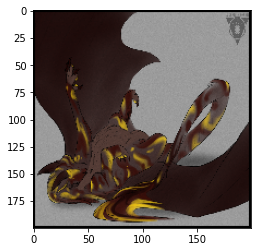

(1341, 1830, 3)


In [18]:
arr_size = cv2.resize(arr, (SIZE, SIZE))
plt.imshow(arr_size)
plt.show()
print(arr.shape)

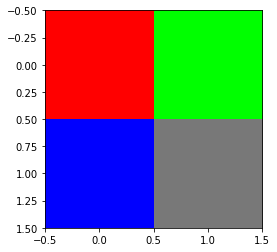

In [21]:
color_1 = [255, 0, 0]
color_2 = [0, 255, 0]
color_3 = [0, 0, 255]
color_4 = [120, 120, 120]
plt.imshow(np.array([[color_1, color_2], [color_3, color_4]]))

# 🦴 **Dataset Preparation**

---



## **Create directory structure**

> Tensorflow has a function called `tf.keras.preprocessing.image.ImageDataGenerator()`, which generates augmented objects for our learning model. Its functions include `flow_from_directory()`, which is what we'll use to funnel our images to the function. One problem: it can only really recognize a certain directory structure. Ideally:

```
../

  /test/

    /furry/

    /notfurry/

  /train/

    /furry/

    /notfurry/
```

So the following lines will help sort through those, with the key points in mind:


1.   We want our dataset to be **randomly divided** by a given ratio (generally, 1:5) for training and testing.
2.   The directories dictate the class in which we'll be sorting the images, not the image file itself. Extra directories in the `/test/` and `/train/` directory will impede on the model (it will show up as an extra class).





In [86]:
from os import makedirs     # create directories
from os import listdir 

from shutil import copyfile # move/swap files

from random import seed     # generate random dispersion
from random import random

In [87]:
  # create directories
  subdirs = ['train', 'test']

  for subdir in subdirs:
    # create label subdirectories
    labels = ['furry', 'notfurry']
    for label in labels:
      dir = os.path.join(DATADIR, subdir, label)
      makedirs(dir, exist_ok=True)

In [88]:
seed(1)

# copy training dataset images into subdirectories
for dir in CATEGORIES:
  head = os.path.join(DATADIR, dir)
  for file in listdir(head):
    src = os.path.join(head, file)
    dst = subdirs[0]
    if random() < RATIO:
      dst = subdirs[1]
    check = file.rsplit("_", 1)[1]
    if check.startswith(dir):
      dst = os.path.join(DATADIR, dst, dir, file)
      print(src)
      print(dst)
      copyfile(src, dst)

NotADirectoryError: ignored

## **Final function**

In [ ]:
def create_dir():
  # organize dataset into a useful structure
  from os import makedirs     # create directories
  from os import listdir 

  from shutil import copyfile # move/swap files

  from random import seed     # generate random dispersion
  from random import random

  # create directories
  subdirs = ['train', 'test']

  for subdir in subdirs:
    # create label subdirectories
    labels = ['furry', 'notfurry']
    for label in labels:
      new = os.path.join(DATADIR, subdir, label)
      makedirs(new, exist_ok=True)
    
  # seed random number generator
  seed(1)
  
  # copy training dataset images into subdirectories
  for dir in CATEGORIES:
    head = os.path.join(DATADIR, dir)
    for file in listdir(head):
      src = os.path.join(head, file)
      dst = subdirs[0]
      if random() < RATIO:
        dst = subdirs[1]
      check = file.rsplit("_", 1)[1]
      if check.startswith(dir):
        dst = os.path.join(DATADIR, dst, dir, file)
        print(src)
        print(dst)
        copyfile(src, dst)

create_dir()

# 🦾 **Modeling with Python's Tensorflow**
---



**Problem: Do we need to resize images to 200x200 before processing?**

`flow_from_directory()` does this for us, through an **iterative process***.

In [160]:
# flow_from_directory = iterative resizing/batch process --> slower, but less memory required
train_it = datagen.flow_from_directory('dataset/dataset/train/',
	class_mode='binary', batch_size=64, target_size=(SIZE, SIZE))
test_it = datagen.flow_from_directory('dataset/dataset/test/',
	class_mode='binary', batch_size=64, target_size=(SIZE, SIZE))

Found 1990 images belonging to 2 classes.
Found 479 images belonging to 2 classes.


## **Creating a Convulational Neural Network (CNN) Model**

**What are convolutional neural networks?**

> In general, convolution + pooling is a common process for image processing (and most do so iteratively for optimal results).
Simply, convolution is to **find** useful things (or features) + pooling **collects** these useful things for learning.
- Images are converted to pixels
- A convolutional window (i.e. 3x3) simplifies what it finds down to a single value, and the window shifts over in an iterative loop.
- Convolutions create a map, and pooling (common: max pooling, finds max value in convolutions) sifts through this convolution map.
- Initial layers of a convolutional window find edges, lines, strong details (accentuate what it finds)
- As you go deeper, you find slight curvatures, finer details, shapes, complex structures, scales (diving into deeper details)
- Deeper details (bias, padding, edge detection) can be discussed on further practicuums.

**Develop a Baseline CNN Model**

A baseline model: A minimum model performance to which all of our other models can be compared + a model architecture for study and improvement.

Model: General architectural principles of the VGG models. For more details on the VGG model, see the 2015 paper “Very Deep Convolutional Networks for Large-Scale Image Recognition.”
- Involves **stacking convolutional layers** with small 3×3 filters followed by a max pooling layer. 
- Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. 
- Padding is used on the convolutional layers to ensure the height and width shapes of the output feature maps matches the inputs.
- We can explore this architecture on the dogs vs cats problem and compare a model with this architecture with 1, 2, and 3 blocks.

Each layer will use the ReLU activation function and the He weight initialization, which are generally best practices.

In [161]:
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D

from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

[**Relu Activation Function**](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)

The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. The rectified linear activation function overcomes the vanishing gradient problem, allowing models to learn faster and perform better.

The ReLU function is **f(x)=max(0,x).**

One way ReLUs improve neural networks is by speeding up training. The gradient computation is very simple (either 0 or 1 depending on the sign of x). Also, the computational step of a ReLU is easy: any negative elements are set to 0.0 -- no exponentials, no multiplication or division operations.



**Weight initialization**

The nodes in neural networks are made of parameters (weights) > calculate a weighted sum of the inputs.

Neural network models are fit using an optimization algorithm called stochastic gradient descent (SGD) that incrementally changes the weights to minimize a loss function, hopefully resulting in an optimal set of weights.

Weight initialization is a procedure to set the weights of a neural network to small random values that define the starting point for the optimization (learning or training) of the neural network model.

The current standard approach for initialization of the weights of neural network layers and nodes that use the rectified linear (ReLU) activation function is called “he” initialization.

The **he initialization method** is calculated as a random number with a Gaussian probability distribution (G) with a mean of 0.0 and a standard deviation of sqrt(2/n), where n is the number of inputs to the node.

In [ ]:
	# convolutional layer block

  # Conv2D(filter, (window_size), activation, kernel_initialization, padding, input_shape(image, 3[rgb]))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	
  # MaxPooling2D(2, 2)
  model.add(MaxPooling2D((2, 2)))

The model will be fit with stochastic gradient descent (SGD) and we will start with a **conservative learning rate** of 0.001 and a **momentum** of 0.9.
An output layer with 1 node and a sigmoid activation will be used and the model will be optimized using the binary cross-entropy (for binary) loss function.

- Alternative optimizers:
  - Adam's learning rate non-fixed model (`optimizer=adam`)

In [ ]:
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 
 # output layer
  model.add(Dense(1, activation='sigmoid'))
  
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
 	# model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

**Final model (oneblock)**

In [162]:
# define cnn model (oneblock)
def define_model():
	
  model = Sequential() # build model by layers\

  # convolutional layer block 

  # Conv2D(filter, (window_size), activation, kernel_initialization, padding, input_shape(image, 3[rgb]))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))

  # MaxPooling2D(2, 2)
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  # model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
  return model

## **Quick model set-up**

In [163]:
model = define_model()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 320000)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               40960128  
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 40,961,153
Trainable params: 40,961,153
Non-trainable params: 0
_________________________________________________________________
None


## **Prepare data**

> Next, we need to prepare the data.
This involves first defining an instance of the ImageDataGenerator that will scale the pixel values to the range of 0-1.

In [164]:
# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0)

### **Clean up directories**

In [165]:
import os
if '.ipynb_checkpoints' in os.listdir('dataset/dataset/test'):
  os.rmdir('dataset/dataset/test/.ipynb_checkpoints')

if '.ipynb_checkpoints' in os.listdir('dataset/dataset/train'):
  os.rmdir('dataset/dataset/train/.ipynb_checkpoints')

  
dir = os.listdir('dataset/dataset/test')
print(dir)
dir = os.listdir('dataset/dataset/train')
print(dir)

['furry', 'notfurry']
['furry', 'notfurry']


### **Prepare iterators**

> We can use the `flow_from_directory()` function on the data generator and create one iterator for each of the `train/` and `test/` directories. We must specify that the problem is a binary classification problem via the “class_mode” argument, and to load the images with the size of 200×200 pixels via the “`target_size`” argument. We will fix the batch size at 32 (since we're dealing with a relatively small ~1k dataset).

In [166]:
# prepare iterators
train_it = datagen.flow_from_directory('dataset/dataset/train/',
	class_mode='binary', batch_size=BATCH_SIZE, target_size=(SIZE, SIZE))
test_it = datagen.flow_from_directory('dataset/dataset/test/',
	class_mode='binary', batch_size=BATCH_SIZE, target_size=(SIZE, SIZE))

Found 1990 images belonging to 2 classes.
Found 479 images belonging to 2 classes.


> The number of steps for the train and test iterators must be specified. This is the number of batches that will comprise one epoch. This can be specified via the length of each iterator, and will be the total number of images in the train and test directories divided by the batch size (32). The model will be fit for 20 epochs, a small number to check if the model can learn the problem.

In [ ]:
# fit model
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
	validation_data=test_it, validation_steps=len(test_it), epochs=EPOCHS, verbose=0)

Once fit, the final model can be evaluated on the test dataset directly and the classification accuracy reported.

In [ ]:
# evaluate model
_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0)) # 91.023

The History contains the model accuracy and loss on the test and training dataset at the end of each epoch. Line plots of these measures over training epochs provide learning curves that we can use to get an idea of whether the model is overfitting, underfitting, or has a good fit.

The summarize_diagnostics() function below takes the history directory and creates a single figure with a line plot of the loss and another for the accuracy. The figure is then saved to file with a filename based on the name of the script. This is helpful if we wish to evaluate many variations of the model in different files and create line plots automatically for each.


In [61]:
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.show()
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

In [ ]:
summarize_diagnostics(history)

In [ ]:
# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset/dataset/train/',
		class_mode='binary', batch_size=64, target_size=(SIZE, SIZE))
	test_it = datagen.flow_from_directory('dataset/dataset/test/',
		class_mode='binary', batch_size=64, target_size=(SIZE, SIZE))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

In [ ]:
# entry point, run the test harness
run_test_harness()

In [ ]:
# define cnn model (twoblock)
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
# define cnn model (threeblock)
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
 
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
 
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
 
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

**Dropout Regularization**
Probabilistically removing, or “dropping out,” inputs to a layer, which may be input variables in the data sample or activations from a previous layer. It has the effect of simulating a large number of networks with very different network structures and, in turn, making nodes in the network generally more robust to the inputs.
https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/

Goals:
- Explore slightly higher dropout rate after VGG blocks ( to better fit overfitting)
- If performance looks like it's stalling, more training epochs might be in order (100 or more)

In [48]:
# define cnn model (threeblock, dropout 20/50)
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

**Image Data Augmentation**
Artificially expand the size of a training dataset by creating modified versions of images in the dataset.
- Act as a regularization technique, adding noise to the training data, and encouraging the model to learn the same features, invariant to their position in the input.
- The augmentations should not be used for the test dataset, as we wish to evaluate the performance of the model on the unmodified photographs.

In [ ]:
# create data generators
# small (10% random hor/ver shift) + random horizontal flips
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
	width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

# keep test images unmodified
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterators
train_it = train_datagen.flow_from_directory('dataset/dataset/train/',
	class_mode='binary', batch_size=64, target_size=(SIZE, SIZE))
test_it = test_datagen.flow_from_directory('dataset/dataset/test/',
	class_mode='binary', batch_size=64, target_size=(SIZE, SIZE))

**Discussion**

- Stochastic nature of algorithm always have variation in results
- As suspected, addition of regularization techniques slow progression of learning algorithms and reduce overfitting, resulting in improved performance
- More training epochs can fix the slow progression however
- Other regularization methods: weight decay, early stopping
- Explore changes to learning algorithm (change to learning rate, learning schedule, or adaptive learning rate like Adam)
- Explore Transfer Learning (pre-trained models)


# Visualization

Accessing Intermediate Layers of CNN

The dark squares indicate small or inhibitory weights and the light squares represent large or excitatory weights. Using this intuition, we can see that the filters on the first row detect a gradient from light in the top left to dark in the bottom right.

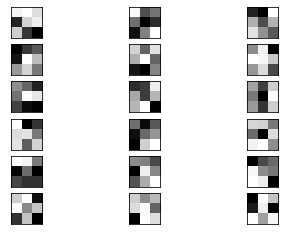

In [93]:
from matplotlib import pyplot as ppt

for layer in model.layers: # viable for oneblock models only
	# check for convolutional layer
	if 'conv' in layer.name:
		  filters, biases = layer.get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 6, 1

for i in range(n_filters):

	# get the filter
	f = filters[:, :, :, i]

	# plot each channel separately
	for j in range(3):
   
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
  
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1

# show the figure
pyplot.show()

In [102]:
# summarize feature map shapes
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

0 conv2d_3 (None, 200, 200, 32)


Model: "model_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3_input (InputLayer)  [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 200, 200, 32)      896       
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________
32


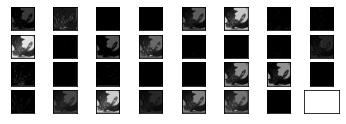

In [133]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()

# view image(s)
for dir in CATEGORIES:
  path = os.path.join(DATADIR, dir)
  for img in os.listdir(path):
    path = os.path.join(path, img)
    break
  break

# load the image with the required shape
img = load_img(path, target_size=(SIZE, SIZE))

# convert the image to an array
img = img_to_array(img)

# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)

# get feature map for first hidden layer
feature_maps = model.predict(img)

print(feature_maps.shape[3])
square = 8
ix = 1
for _ in range(square):

  if ix == feature_maps.shape[3]:
    break

  for _ in range(square):
    # specify subplot and turn of axis
    ax = pyplot.subplot(square, square, ix)
    ax.set_xticks([])
    ax.set_yticks([])
  
    if ix == feature_maps.shape[3]:
      break

    # plot filter channel in grayscale
    pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
    ix += 1

# show the figure
pyplot.show()